In [1]:
import os
import pandas as pd
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from scipy.ndimage import zoom
from tqdm import tqdm
import itk
import SimpleITK as sitk
from typing import List
import psutil
import time
# from em_algorithm import em_algorithm
from tissue_model_segmentation import TissueModelSegmentation
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap

## Utility Functions

In [2]:
def readNiftiImage(file_path):
        # Read Nifti image
        try:
            niftiImage = nib.load(file_path).get_fdata()
            return niftiImage, nib.load(file_path).affine
        except Exception as e:
            print(f"Error reading NIFTI image from {file_path}: {str(e)}")           


def get_file_paths(folder_path):
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".nii.gz"):
                file_paths.append(os.path.join(root, file))
    return sorted(file_paths)

# Evaluation

def calculate_dice_scores(pred, gt, labels=[1, 2, 3]):
        dice_scores = {}
        for label in labels:
            pred_count = np.sum(pred == label)
            gt_count = np.sum(gt == label)
            intersection = np.sum((pred == label) & (gt == label))
            if pred_count + gt_count == 0:
                dice_score = 1.0  # Perfect match if label is absent in both
            else:
                dice_score = 2 * intersection / (pred_count + gt_count)
            dice_scores[label] = dice_score
        return dice_scores
    
# Function to create a color-coded boxplot of Dice scores without black background
def plot_dice_score_boxplot(metrics_df):

    # Reshape the data for Seaborn
    melted_df = metrics_df.melt(id_vars=['Image'], value_vars=['CSF', 'WM', 'GM'],
                                var_name='Tissue', value_name='Dice Score')

    # Define softer colors for each tissue type
    tissue_palette = {'CSF': '#a8dadc', 'WM': '#457b9d', 'GM': '#1d3557'}

    # Plot with Seaborn
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=melted_df, x='Tissue', y='Dice Score', palette=tissue_palette, width=0.4)  # Adjust width here
    plt.title("Dice Score Distribution for CSF, WM, and GM Using EM(Kmeans init.) Tissue Model and Label Propagation aposteriori in loop")
    plt.ylabel("Dice Score")
    plt.xlabel("Tissue Type")

    # Add legend
    legend_handles = [mpatches.Patch(color=color, label=tissue) for tissue, color in tissue_palette.items()]
    plt.legend(handles=legend_handles, title="Tissue Types")

    plt.show()

    
def normalize_image(vec, new_min=0, new_max=255):
        min_val = np.min(vec)
        max_val = np.max(vec)
        normalized_vec = (vec - min_val) / (max_val - min_val) * (new_max - new_min) + new_min
        return normalized_vec.astype(np.uint8)

In [3]:
def plot_comparison_grid(preds, gts, slice_indices=None, cmap_colors=None, title="Comparison of Ground Truth and Prediction"):
    """
    Generalized function to visualize a 3x3 grid of GT vs. Prediction for multiple images with custom tissue names and colors.
    
    Args:
        preds (list of np.ndarray): List of predicted segmentation arrays.
        gts (list of np.ndarray): List of ground truth segmentation arrays.
        slice_indices (list of int, optional): Indices for axial, coronal, and sagittal views. 
                                               Defaults to the middle slices of the first image.
        cmap_colors (dict, optional): Dictionary mapping tissue names to colors.
                                       Defaults to white, dark grey, and ash grey for White Matter, CSF, and Grey Matter.
        title (str, optional): Title for the entire grid. Defaults to "Comparison of Ground Truth and Prediction".
    """
    if slice_indices is None:
        # Default to middle slices for the first image
        img_shape = gts[0].shape
        slice_indices = [img_shape[2] // 2, img_shape[1] // 2, img_shape[0] // 2]

    if cmap_colors is None:
        # Default colors: White (WM), Dark Grey (CSF), Grey/Ash (GM)
        cmap_colors = {
            0: 'black',         # Background
            1: '#555555',       # Dark Grey for CSF
            2: 'white',         # White for White Matter
            3: '#AAAAAA'        # Grey for Grey Matter
        }

    # Tissue names for legend
    tissue_names = {1: "CSF", 2: "White Matter", 3: "Grey Matter"}

    # Create a colormap
    cmap = ListedColormap([cmap_colors[key] for key in sorted(cmap_colors.keys())])

    num_images = min(len(preds), len(gts), 3)  # Limit to 3 images
    fig, axes = plt.subplots(num_images, 6, figsize=(18, 12), facecolor='black')

    for ax in axes.ravel():
        ax.set_facecolor('black')
        ax.axis('off')

    for i in range(num_images):
        pred = preds[i]
        gt = gts[i]

        for j, (view, slice_index) in enumerate(zip(['Axial', 'Coronal', 'Sagittal'], slice_indices)):
            if view == 'Axial':
                gt_slice = gt[:, :, slice_index]
                pred_slice = pred[:, :, slice_index]
            elif view == 'Coronal':
                gt_slice = gt[:, slice_index, :]
                pred_slice = pred[:, slice_index, :]
            elif view == 'Sagittal':
                gt_slice = gt[slice_index, :, :]
                pred_slice = pred[slice_index, :, :]

            # Ground Truth
            axes[i, j * 2].imshow(gt_slice, cmap=cmap, vmin=0, vmax=len(cmap_colors) - 1)
            axes[i, j * 2].set_title(f"Image {i+1} - {view} GT", color='white')

            # Prediction
            axes[i, j * 2 + 1].imshow(pred_slice, cmap=cmap, vmin=0, vmax=len(cmap_colors) - 1)
            axes[i, j * 2 + 1].set_title(f"Image {i+1} - {view} Pred", color='white')

    # Add a suptitle for the entire grid
    fig.suptitle(title, fontsize=16, color='white')

    # Add a legend
    legend_handles = [
        mpatches.Patch(color=cmap_colors[key], label=tissue_names[key]) for key in tissue_names.keys()
    ]
    fig.legend(
        handles=legend_handles, loc='lower center', ncol=len(tissue_names),
        title="Tissue Types", fontsize=12, facecolor='black', edgecolor='white', 
        frameon=True, title_fontsize=13, labelcolor='white'
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout for suptitle and legend
    plt.show()



### Data preprocessing for EM

In [4]:
def em_preprocessing(image_data, mask_data):
    """
    Normalize an image and extract data based on a ground truth mask.

    Args:
        image_data (numpy.ndarray): Input image data.
        mask_data (numpy.ndarray): Ground truth mask data.

    Returns:
        numpy.ndarray: Extracted and normalized data from the image where the mask is greater than 0.
    """
    # Check for dimensional alignment
    if image_data.shape != mask_data.shape:
        raise ValueError(f"Image and mask dimensions do not match: {image_data.shape} vs {mask_data.shape}")

    # Normalize the image
    # normalized_image_data = (image_data - np.mean(image_data)) / np.std(image_data)

    # Extract data where mask is greater than 0
    extracted_data = image_data[mask_data > 0]

    # Validate that data has been extracted
    if extracted_data.size == 0:
        raise ValueError("No data was extracted. Check the mask for valid regions.")

    return extracted_data.reshape(-1, 1)  # Return as a column vector

def em_post_processing(data_1d, gt_data, mu_em, responsibilities, label_order=(1, 3, 2), num_classes=3):
    """
    Post-process the results of the EM algorithm to map labels consistently and reconstruct a 3D label map.

    Args:
        data_1d (numpy.ndarray): 1D array of data used in the EM algorithm.
        gt_data (numpy.ndarray): Ground truth mask used for extracting valid regions.
        mu_em (numpy.ndarray): Mean values for each cluster from the EM algorithm.
        responsibilities (numpy.ndarray): Responsibilities matrix from the EM algorithm.
        label_order (list or None): Desired order of labels (e.g., [1, 2, 3]). Defaults to ascending order.
        num_classes (int): Number of clusters (default: 3).

    Returns:
        numpy.ndarray: 3D label map with consistent labels.
    """
    # Set default label order to ascending order (1, 2, 3, ...)
    if label_order is None:
        label_order = list(range(1, num_classes + 1))  # Default to [1, 2, ..., num_classes]

    # Ensure mu_em is a 2D array
    if mu_em.ndim == 1:
        mu_em = mu_em.reshape(-1, 1)

    # Assign labels based on maximum responsibility
    labels = np.argmax(responsibilities, axis=1)

    # Create a mapping based on the specified label order
    sorted_indices = np.argsort(mu_em[:, 0])  # Sort by mean intensities
    label_mapping = {sorted_indices[i]: label_order[i] for i in range(num_classes)}  # Use provided label order

    # Map the labels to consistent labels
    mapped_labels = np.array([label_mapping.get(label, 0) for label in labels])  # Handle unmapped labels

    # Create a 3D label map initialized to zero
    label3d = np.zeros_like(gt_data)

    # Assign the mapped labels to the corresponding locations in the 3D label map
    label3d[gt_data > 0] = mapped_labels

    return label3d

def initialize_clusters(data, n_clusters=3, random_state=0):
    """
    Initialize clusters using kmeans
    """
    
    # Ensure n_clusters is valid
    if not isinstance(n_clusters, int):
        raise ValueError(f"n_clusters must be an integer. Got {n_clusters}.")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data)
    mu = kmeans.cluster_centers_
    labels = kmeans.labels_
    sigma = np.array([np.std(data[labels == i], axis=0) for i in range(n_clusters)])
    pi = np.ones(n_clusters) / n_clusters

    return mu, sigma, pi


### EM Algorithm

In [ ]:
# # Function to calculate the Gaussian probability
# def gaussian_pdf(x, mu, cov):
#     return multivariate_normal.pdf(x, mean=mu, cov=cov)


# def em_algorithm(data, mu, sigma, pi, max_iter=100, tol=1e-6, atlas_responsibility=None, freq=1):
#     n_samples, n_features = data.shape
#     n_clusters = mu.shape[0]

#     # Validate parameters
#     if atlas_responsibility is not None and atlas_responsibility.shape != (n_samples, n_clusters):
#         raise ValueError("atlas_responsibility must have shape (n_samples, n_clusters).")

#     responsibilities = np.zeros((n_samples, n_clusters))
#     log_likelihoods = []

#     for iter in range(max_iter):
#         ### E-Step
#         for i in range(n_clusters):
#             cov = np.diag(sigma[i]**2 + 1e-6)  # Add small value to diagonal
#             responsibilities[:, i] = pi[i] * gaussian_pdf(data, mu[i], cov)

#         # Normalize responsibilities
#         responsibility_sum = np.sum(responsibilities, axis=1, keepdims=True)
#         responsibility_sum[responsibility_sum == 0] = 1  # Prevent division by zero
#         responsibilities /= responsibility_sum

#         ### Apply atlas responsibility
#         if atlas_responsibility is not None and (iter + 1) % freq == 0:
#             responsibilities *= atlas_responsibility
#             responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

#         ### M-Step
#         N_k = responsibilities.sum(axis=0)
#         for i in range(n_clusters):
#             mu[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]
#             diff = data - mu[i]
#             sigma[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])
#         pi = N_k / n_samples

#         ### Log-Likelihood
#         log_likelihood = np.sum(np.log(np.sum([pi[k] * gaussian_pdf(data, mu[k], np.diag(sigma[k]**2 + 1e-6))
#                                                for k in range(n_clusters)], axis=0) + 1e-6))
#         log_likelihoods.append(log_likelihood)

#         # Convergence check
#         if iter > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
#             print(f"Converged at iteration {iter}")
#             break

#     return mu, sigma, pi, log_likelihoods, responsibilities


In [5]:
import numpy as np

def gaussian_pdf(data, mean, cov):
    """Computes the Gaussian PDF."""
    n_features = data.shape[1]
    det = np.linalg.det(cov)
    if det == 0:
        det = 1e-6  # Avoid division by zero
    norm_const = 1 / np.sqrt((2 * np.pi) ** n_features * det)
    inv_cov = np.linalg.inv(cov + np.eye(cov.shape[0]) * 1e-6)  # Regularization for numerical stability
    diff = data - mean
    return norm_const * np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1))

def em_algorithm(data, mu, sigma, pi, max_iter=100, tol=1e-6, atlas_responsibility=None, freq=1):
    n_samples, n_features = data.shape
    n_clusters = mu.shape[0]

    # Validate parameters
    if atlas_responsibility is not None and atlas_responsibility.shape != (n_samples, n_clusters):
        raise ValueError("atlas_responsibility must have shape (n_samples, n_clusters).")
    if freq <= 0:
        raise ValueError("freq must be a positive integer.")

    responsibilities = np.zeros((n_samples, n_clusters))
    log_likelihoods = []

    for iter in range(max_iter):
        ### E-Step
        for i in range(n_clusters):
            cov = np.diag(sigma[i]**2 + 1e-6)  # Add small value to diagonal for numerical stability
            responsibilities[:, i] = pi[i] * gaussian_pdf(data, mu[i], cov)

        # Normalize responsibilities
        responsibility_sum = np.sum(responsibilities, axis=1, keepdims=True)
        responsibility_sum[responsibility_sum == 0] = 1  # Prevent division by zero
        responsibilities /= responsibility_sum

        ### Apply atlas responsibility based on frequency
        if atlas_responsibility is not None and freq > 0 and (iter + 1) % freq == 0:
            responsibilities *= atlas_responsibility
            responsibility_sum = np.sum(responsibilities, axis=1, keepdims=True)
            responsibility_sum[responsibility_sum == 0] = 1  # Avoid division by zero after applying atlas
            responsibilities /= responsibility_sum

        ### M-Step
        N_k = responsibilities.sum(axis=0)
        for i in range(n_clusters):
            if N_k[i] == 0:  # Avoid division by zero for empty clusters
                continue
            mu[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]
            diff = data - mu[i]
            sigma[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])
        pi = N_k / n_samples

        ### Log-Likelihood
        try:
            log_likelihood = np.sum(np.log(np.sum([pi[k] * gaussian_pdf(data, mu[k], np.diag(sigma[k]**2 + 1e-6))
                                                   for k in range(n_clusters)], axis=0) + 1e-6))
        except Exception as e:
            print(f"Error in log-likelihood calculation: {e}")
            break
        log_likelihoods.append(log_likelihood)

        # Convergence check
        if iter > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iter}")
            break

    return mu, sigma, pi, log_likelihoods, responsibilities


In [6]:
tissue_model_df = pd.read_csv('TissueModel.csv')

In [8]:
# Do it for all the images in the test set

tissue_model = tissue_model_df[['CSF', 'WM', 'GM']]
tissue_model = tissue_model.to_numpy()

In [10]:
# Step-1: Load the image and mask data and preprocess the data

# open an image
image_path = 'test_set/testing-images/1018.nii.gz'
mask_path = 'test_set/testing-labels/1018_3C.nii.gz'

csf_path = 'lp-prob-segmentations\\1018.nii_CSF_reg.nii.gz'
wm_path = 'lp-prob-segmentations\\1018.nii_WM_reg.nii.gz'
gm_path = 'lp-prob-segmentations\\1018.nii_GM_reg.nii.gz'

image, _ = readNiftiImage(image_path)
mask, _ = readNiftiImage(mask_path)

csf, _ = readNiftiImage(csf_path)
wm, _ = readNiftiImage(wm_path)
gm, _ = readNiftiImage(gm_path)

# normalize the image removing the background

image = np.where(mask > 0, image, 0)
masked_image = image[mask > 0]
image[mask > 0] = normalize_image(masked_image)

# Load and preprocess the image data
data = em_preprocessing(image, mask)

Error reading NIFTI image from lp-prob-segmentations\1018.nii_CSF_reg.nii.gz: No such file or no access: 'lp-prob-segmentations/1018.nii_CSF_reg.nii.gz'


TypeError: cannot unpack non-iterable NoneType object

## Vanilla EM

In [ ]:
# Do it for all the images in the test set

image_paths = get_file_paths('test_set\\testing-images')
# exclude images [1019, 1023, 1039]
# image_paths = [file for file in image_paths if '1019' not in file and '1023' not in file and '1039' not in file]
mask_paths = get_file_paths('test_set\\testing-labels')
# mask_paths = [file for file in mask_paths if '1019' not in file and '1023' not in file and '1039' not in file]

# Initialize a metrics dictionary to store Dice scores
metrics = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}

# Loop through each image and mask
for image_file, mask_file in zip(image_paths, mask_paths):
    
    image_name = os.path.basename(image_file).split('.')[0]  # Extract image ID
    mask_name = os.path.basename(mask_file).split('.')[0]  # Extract mask ID
    print(f"Processing {image_name} and {mask_name}...")

    # Step 1: Load and preprocess the image and mask
    image, _ = readNiftiImage(image_file)
    mask, _ = readNiftiImage(mask_file)

    # Normalize the image while removing the background
    image = np.where(mask > 0, image, 0)
    masked_image = image[mask > 0]
    image[mask > 0] = normalize_image(masked_image)

    # Prepare data for EM
    data = em_preprocessing(image, mask)
    
    # Initialize clusters using kmeans
    mu_init, sigma_init, pi_init = initialize_clusters(data, n_clusters=3, random_state=0)

    # Step 2: Run the EM algorithm
    mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(
        data, mu_init, sigma_init, pi_init, max_iter=100, tol=1e-6
    )

    # Debugging EM results
    print(f"Final mu for {image_file}: {mu.flatten()}")
    
    # Step 3: Post-process the results
    label3d = em_post_processing(data, mask, mu, responsibilities, num_classes=3)

    # Calculate Dice scores
    dice_scores = calculate_dice_scores(label3d, mask, labels=[1, 2, 3])
    metrics['Image'].append(image_file)
    metrics['CSF'].append(dice_scores[1])
    metrics['WM'].append(dice_scores[2])
    metrics['GM'].append(dice_scores[3])

    print(f"Dice scores for {image_file}: CSF={dice_scores[1]:.4f}, WM={dice_scores[2]:.4f}, GM={dice_scores[3]:.4f}")

# Save metrics to a CSV file
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('Result\\EM\\DiceScores.csv', index=False)

In [ ]:
# plot the dice scores
plot_dice_score_boxplot(metrics_df)

## Tissue Model + Label Propagation

### Calculate the multiplication  Responsibility 

In [ ]:
# Step-2 : Use tissue model to get the initial responsabilities for the EM algorithm
tissue_model = tissue_model_df[['CSF', 'WM', 'GM']]
tissue_model = tissue_model.to_numpy()

# map the tissue model probabilities to the intensities to get the initial responsabilities
responsibilities_tm = np.zeros((*data.shape, 3))  # Include all spatial dimensions and 3 for CSF, WM, GM

# Assign tissue model probabilities to the respective voxels
for i in range(1, 256):
    responsibilities_tm[data == i, :] = tissue_model[i - 1]
    
# Assuming `responsabilities` has the shape (1172736, 1, 3)
responsibilities_tm = np.squeeze(responsibilities_tm, axis=1)

# Ensure CSF, WM, and GM probabilities are masked to exclude the background
csf = np.where(mask > 0, csf, 0)  # Keep CSF probabilities only for foreground pixels
wm = np.where(mask > 0, wm, 0)    # Keep WM probabilities only for foreground pixels
gm = np.where(mask > 0, gm, 0)    # Keep GM probabilities only for foreground pixels

# Initialize responsibilities array for only foreground voxels
foreground_indices = np.where(mask > 0)  # Get the indices of foreground pixels
responsibilities_lp = np.zeros((len(foreground_indices[0]), 3))  # Shape [num_foreground_voxels, 3]

# Assign probabilities to the responsibilities array
responsibilities_lp[:, 0] = csf[foreground_indices]  # CSF probabilities for foreground
responsibilities_lp[:, 1] = wm[foreground_indices]   # WM probabilities for foreground
responsibilities_lp[:, 2] = gm[foreground_indices]   # GM probabilities for foreground

# If necessary, reshape the responsibilities array for further processing
responsibilities = responsibilities_tm*responsibilities_lp

responsibilities.shape

In [ ]:
n_clusters = 3
mu_init = np.zeros((n_clusters, 1))

### M-Step: Update parameters
N_k = responsibilities.sum(axis=0)

# Update mu (means)
for i in range(n_clusters):
    mu_init[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i] 

In [ ]:
# Apply em_post processing to get the final labels

label_order = [1, 3, 2]  # Define the desired label order
num_classes = 3

label_3d = em_post_processing(data, mask, mu_init, responsibilities, label_order, num_classes)


# Evaluate the results
gt = mask[mask > 0]
pred = label_3d[mask > 0]

metrics = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}

# Compute Dice scores
dice_scores = calculate_dice_scores(pred, gt, labels=label_order)
metrics['Image'].append(f'Image_{i+1}')
metrics['CSF'].append(dice_scores[1])
metrics['WM'].append(dice_scores[2])
metrics['GM'].append(dice_scores[3])

print(f"Dice scores for Image_{i+1}: CSF={dice_scores[1]:.4f}, WM={dice_scores[2]:.4f}, GM={dice_scores[3]:.4f}")


### Evaluation for TM+LP

In [ ]:


# Paths to directories
prob_atlas_dir = 'lp-prob-segmentations'
image_paths = get_file_paths('test_set\\testing-images')
# exclude images [1019, 1023, 1039]
image_paths = [file for file in image_paths if '1019' not in file and '1023' not in file and '1039' not in file]
mask_paths = get_file_paths('test_set\\testing-labels')
mask_paths = [file for file in mask_paths if '1019' not in file and '1023' not in file and '1039' not in file]

# Initialize a metrics dictionary to store Dice scores
metrics = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}

predictions = []

# Loop through each image and mask
for image_file, mask_file in zip(image_paths, mask_paths):
    
    image_name = os.path.basename(image_file).split('.')[0]  # Extract image ID
    mask_name = os.path.basename(mask_file).split('.')[0]  # Extract mask ID
    print(f"Processing {image_name} and {mask_name}...")

    # Step 1: Load and preprocess the image and mask
    image, _ = readNiftiImage(image_file)
    mask, _ = readNiftiImage(mask_file)

    # Normalize the image while removing the background
    image = np.where(mask > 0, image, 0)
    masked_image = image[mask > 0]
    image[mask > 0] = normalize_image(masked_image)

    # Prepare data for EM
    data = em_preprocessing(image, mask)

    # # Debugging check
    # print(f"Unique values in data for {image_file}: {np.unique(data)}")

    # Step 2: Load the probabilistic atlases for label propagation
    image_name = os.path.basename(image_file).split('.')[0]  # Extract image ID
    csf_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_CSF_reg.nii.gz")
    wm_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_WM_reg.nii.gz")
    gm_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_GM_reg.nii.gz")
    
    # map the tissue model probabilities to the intensities to get the initial responsabilities
    responsibilities_tm = np.zeros((*data.shape, 3))  # Include all spatial dimensions and 3 for CSF, WM, GM

    # Assign tissue model probabilities to the respective voxels
    for i in range(1, 256):
        responsibilities_tm[data == i, :] = tissue_model[i - 1]
    
    # Assuming `responsabilities` has the shape (1172736, 1, 3)
    responsibilities_tm = np.squeeze(responsibilities_tm, axis=1)

    csf, _ = readNiftiImage(csf_path)
    wm, _ = readNiftiImage(wm_path)
    gm, _ = readNiftiImage(gm_path)

    # Mask the probabilistic atlases to exclude background
    csf = np.where(mask > 0, csf, 0)
    wm = np.where(mask > 0, wm, 0)
    gm = np.where(mask > 0, gm, 0)

    # Initialize responsibilities using probabilistic atlases
    responsibilities_lp = np.zeros((data.size, 3))  # Shape: [num_voxels, 3]
    foreground_indices = np.where(mask > 0)  # Indices of foreground voxels
    responsibilities_lp[:, 0] = csf[foreground_indices]  # CSF probabilities
    responsibilities_lp[:, 1] = wm[foreground_indices]   # WM probabilities
    responsibilities_lp[:, 2] = gm[foreground_indices]   # GM probabilities
    
    responsibilities = responsibilities_tm*responsibilities_lp

    # # Debugging responsibility initialization
    # print(f"Responsibility initialization for {image_name}: {responsibilities[:10]}")

    # Step 3: Calculate initial parameters for the EM algorithm
    n_clusters = 3
    n_samples = data.size
    mu_init = np.zeros((n_clusters, 1))
    sigma_init = np.zeros((n_clusters, 1))
    N_k = responsibilities.sum(axis=0)

    for i in range(n_clusters):
        mu_init[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]
        diff = data - mu_init[i]
        sigma_init[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])
    pi_init = N_k / n_samples

    # Debugging initial parameters
    # print(f"Initial mu for {image_file}: {mu_init.flatten()}")
    # print(f"Initial sigma for {image_file}: {sigma_init.flatten()}")

    # Step 4: Post-process the results
    label3d = em_post_processing(data, mask, mu_init, responsibilities, num_classes=3)
    
    predictions.append(label3d)

    # Calculate Dice scores
    dice_scores = calculate_dice_scores(label3d, mask, labels=[1, 2, 3])
    metrics['Image'].append(image_file)
    metrics['CSF'].append(dice_scores[1])
    metrics['WM'].append(dice_scores[2])
    metrics['GM'].append(dice_scores[3])

    print(f"Dice scores for {image_file}: CSF={dice_scores[1]:.4f}, WM={dice_scores[2]:.4f}, GM={dice_scores[3]:.4f}")

# Save metrics to a CSV file
metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv('DiceScores.csv', index=False)

Processing 1003 and 1003_3C...
Dice scores for test_set\testing-images\1003.nii.gz: CSF=0.6858, WM=0.8219, GM=0.9096
Processing 1004 and 1004_3C...
Dice scores for test_set\testing-images\1004.nii.gz: CSF=0.8939, WM=0.9133, GM=0.9414
Processing 1005 and 1005_3C...
Dice scores for test_set\testing-images\1005.nii.gz: CSF=0.8265, WM=0.8793, GM=0.9249
Processing 1018 and 1018_3C...
Dice scores for test_set\testing-images\1018.nii.gz: CSF=0.8503, WM=0.8477, GM=0.9179
Processing 1024 and 1024_3C...
Dice scores for test_set\testing-images\1024.nii.gz: CSF=0.8768, WM=0.9076, GM=0.9409
Processing 1025 and 1025_3C...
Dice scores for test_set\testing-images\1025.nii.gz: CSF=0.8091, WM=0.8790, GM=0.9331
Processing 1038 and 1038_3C...
Dice scores for test_set\testing-images\1038.nii.gz: CSF=0.8871, WM=0.9039, GM=0.9397
Processing 1101 and 1101_3C...
Dice scores for test_set\testing-images\1101.nii.gz: CSF=0.8885, WM=0.9002, GM=0.9389
Processing 1104 and 1104_3C...
Dice scores for test_set\testing-

In [13]:
# plot comparison grid

# load the ground truth and prediction
gt_masks = [readNiftiImage(mask_file)[0] for mask_file in mask_paths]


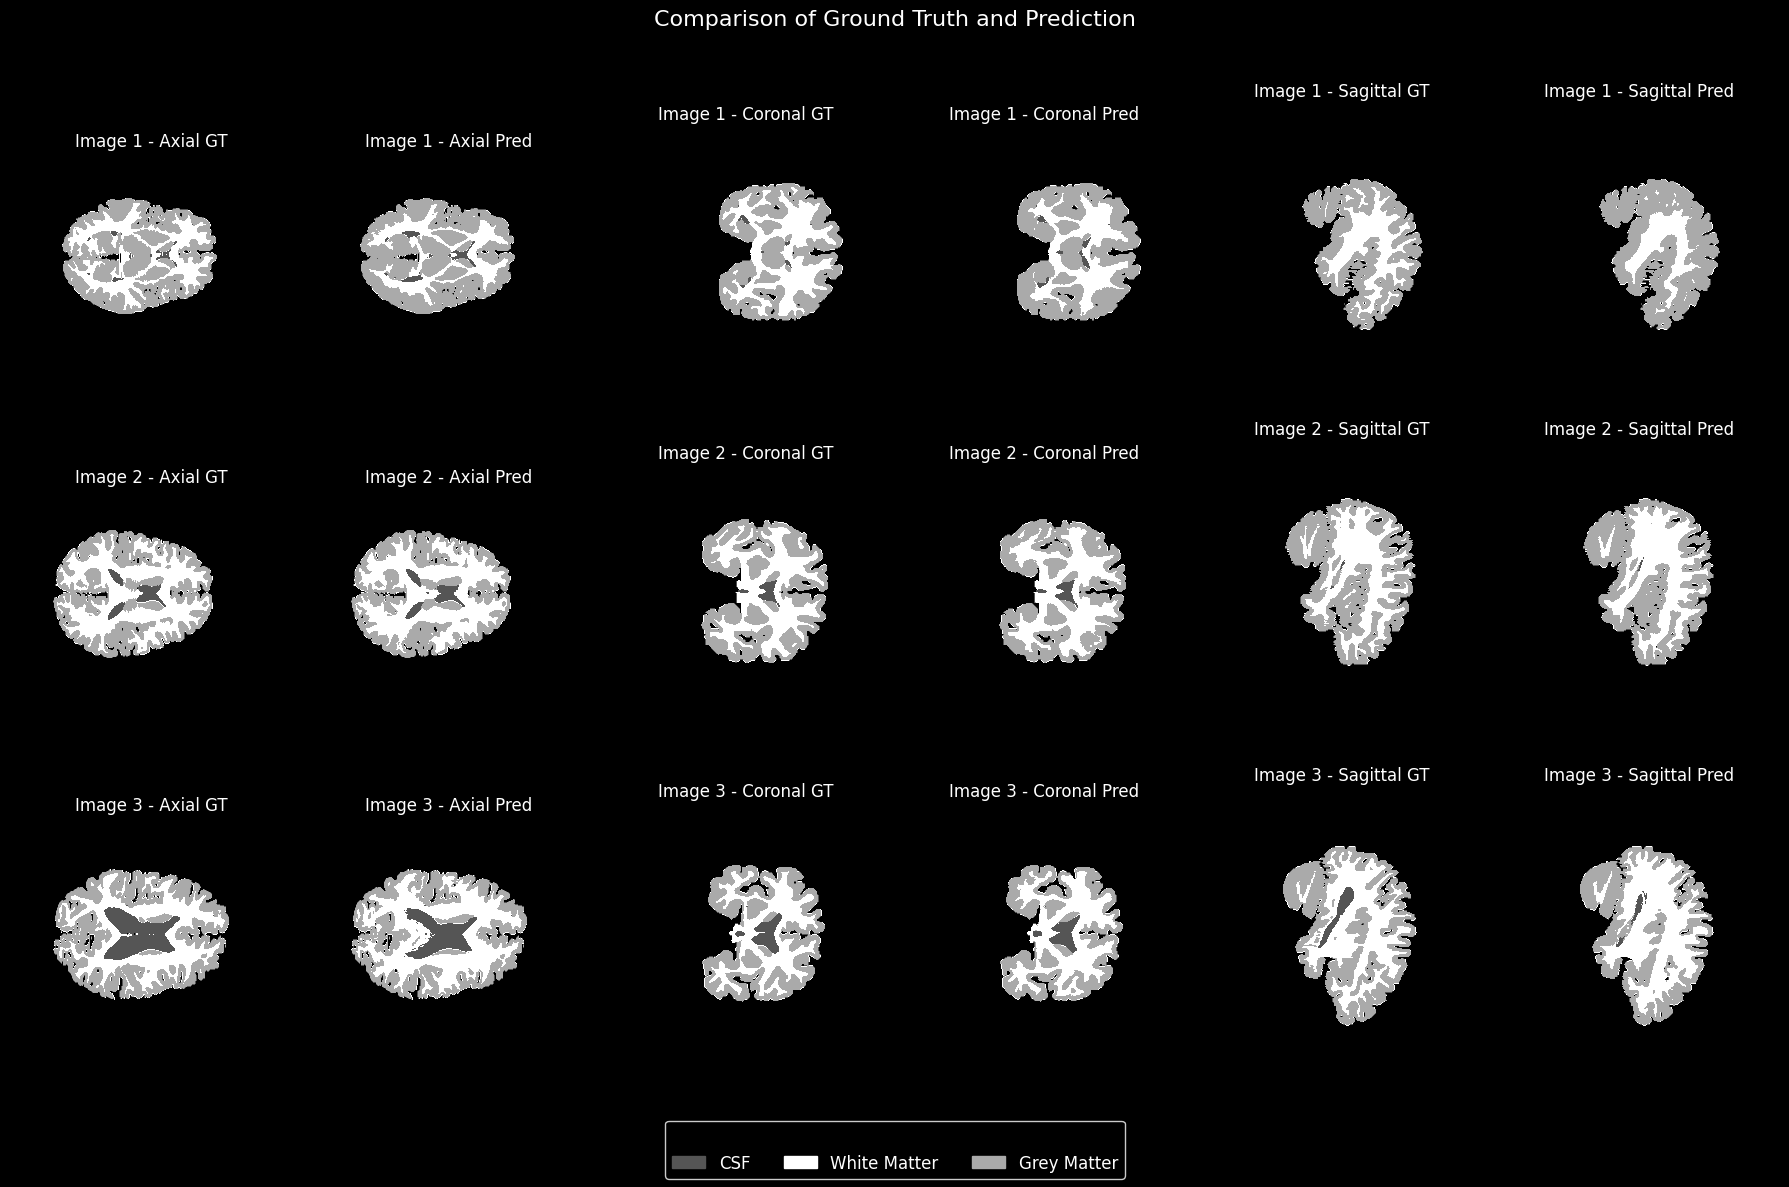

In [21]:
# Plot the comparison grid
plot_comparison_grid(predictions, gt_masks, slice_indices=[150, 150, 150], title="Comparison of Ground Truth and Prediction")

In [ ]:
# load the metrics from the csv file
tm_lp_metrics = pd.read_csv('Result\\TM+LP\\DiceScores.csv')

# Plot the Dice scores
plot_dice_score_boxplot(tm_lp_metrics)


## EM + TM + EP (Initialization)

In [59]:
# Do it for all the images in the test set

# Paths to directories
prob_atlas_dir = 'lp-prob-segmentations'
image_paths = get_file_paths('test_set\\testing-images')
# exclude images [1019, 1023, 1039]
image_paths = [file for file in image_paths if '1019' not in file and '1023' not in file and '1039' not in file]
mask_paths = get_file_paths('test_set\\testing-labels')
mask_paths = [file for file in mask_paths if '1019' not in file and '1023' not in file and '1039' not in file]

# Initialize a metrics dictionary to store Dice scores
metrics = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}

# Loop through each image and mask
for image_file, mask_file in zip(image_paths, mask_paths):
    
    image_name = os.path.basename(image_file).split('.')[0]  # Extract image ID
    mask_name = os.path.basename(mask_file).split('.')[0]  # Extract mask ID
    print(f"Processing {image_name} and {mask_name}...")

    # Step 1: Load and preprocess the image and mask
    image, _ = readNiftiImage(image_file)
    mask, _ = readNiftiImage(mask_file)

    # Normalize the image while removing the background
    image = np.where(mask > 0, image, 0)
    masked_image = image[mask > 0]
    image[mask > 0] = normalize_image(masked_image)

    # Prepare data for EM
    data = em_preprocessing(image, mask)

    # # Debugging check
    # print(f"Unique values in data for {image_file}: {np.unique(data)}")

    # Step 2: Load the probabilistic atlases for label propagation
    image_name = os.path.basename(image_file).split('.')[0]  # Extract image ID
    csf_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_CSF_reg.nii.gz")
    wm_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_WM_reg.nii.gz")
    gm_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_GM_reg.nii.gz")
    
    # map the tissue model probabilities to the intensities to get the initial responsabilities
    responsibilities_tm = np.zeros((*data.shape, 3))  # Include all spatial dimensions and 3 for CSF, WM, GM

    # Assign tissue model probabilities to the respective voxels
    for i in range(1, 256):
        responsibilities_tm[data == i, :] = tissue_model[i - 1]
    
    # Assuming `responsabilities` has the shape (1172736, 1, 3)
    responsibilities_tm = np.squeeze(responsibilities_tm, axis=1)

    csf, _ = readNiftiImage(csf_path)
    wm, _ = readNiftiImage(wm_path)
    gm, _ = readNiftiImage(gm_path)

    # Mask the probabilistic atlases to exclude background
    csf = np.where(mask > 0, csf, 0)
    wm = np.where(mask > 0, wm, 0)
    gm = np.where(mask > 0, gm, 0)

    # Initialize responsibilities using probabilistic atlases
    responsibilities_lp = np.zeros((data.size, 3))  # Shape: [num_voxels, 3]
    foreground_indices = np.where(mask > 0)  # Indices of foreground voxels
    responsibilities_lp[:, 0] = csf[foreground_indices]  # CSF probabilities
    responsibilities_lp[:, 1] = wm[foreground_indices]   # WM probabilities
    responsibilities_lp[:, 2] = gm[foreground_indices]   # GM probabilities
    
    responsibilities = responsibilities_tm*responsibilities_lp

    # # Debugging responsibility initialization
    # print(f"Responsibility initialization for {image_name}: {responsibilities[:10]}")

    # Step 3: Calculate initial parameters for the EM algorithm
    n_clusters = 3
    n_samples = data.size
    mu_init = np.zeros((n_clusters, 1))
    sigma_init = np.zeros((n_clusters, 1))
    N_k = responsibilities.sum(axis=0)

    for i in range(n_clusters):
        mu_init[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]
        diff = data - mu_init[i]
        sigma_init[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])
    pi_init = N_k / n_samples

    # Debugging initial parameters
    # print(f"Initial mu for {image_file}: {mu_init.flatten()}")
    # print(f"Initial sigma for {image_file}: {sigma_init.flatten()}")

    # Step 4: Run the EM algorithm
    mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(
        data, mu_init, sigma_init, pi_init, max_iter=100, tol=1e-6
    )

    # Debugging EM results
    print(f"Final mu for {image_file}: {mu.flatten()}")

    # Step 5: Post-process the results
    label3d = em_post_processing(data, mask, mu, responsibilities, num_classes=3)

    # Calculate Dice scores
    dice_scores = calculate_dice_scores(label3d, mask, labels=[1, 2, 3])
    metrics['Image'].append(image_file)
    metrics['CSF'].append(dice_scores[1])
    metrics['WM'].append(dice_scores[2])
    metrics['GM'].append(dice_scores[3])

    print(f"Dice scores for {image_file}: CSF={dice_scores[1]:.4f}, WM={dice_scores[2]:.4f}, GM={dice_scores[3]:.4f}")

# Save metrics to a CSV file
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('Result\\EM+TM+LP\\DiceScores.csv', index=False)

Processing 1003 and 1003_3C...
Final mu for test_set\testing-images\1003.nii.gz: [ 67.3255675  140.98512968  95.76324091]
Dice scores for test_set\testing-images\1003.nii.gz: CSF=0.0313, WM=0.8276, GM=0.6924
Processing 1004 and 1004_3C...
Final mu for test_set\testing-images\1004.nii.gz: [ 15.46335896 184.73587436 112.08742651]
Dice scores for test_set\testing-images\1004.nii.gz: CSF=0.4127, WM=0.8973, GM=0.9342
Processing 1005 and 1005_3C...
Final mu for test_set\testing-images\1005.nii.gz: [ 11.97531231 195.48446324 117.33157428]
Dice scores for test_set\testing-images\1005.nii.gz: CSF=0.7498, WM=0.8654, GM=0.9206
Processing 1018 and 1018_3C...
Final mu for test_set\testing-images\1018.nii.gz: [ 74.58981594 147.46679576  89.6644591 ]
Dice scores for test_set\testing-images\1018.nii.gz: CSF=0.0786, WM=0.8926, GM=0.9318
Processing 1024 and 1024_3C...
Final mu for test_set\testing-images\1024.nii.gz: [ 14.44878369 190.33627541 113.7342507 ]
Dice scores for test_set\testing-images\1024.n

In [ ]:
# Plot the Dice score boxplot
plot_dice_score_boxplot(metrics_df)

### EM+TM+LP(Kmeans Initialization)

In [ ]:
# Do it for all the images in the test set

# Paths to directories
prob_atlas_dir = 'lp-prob-segmentations'
image_paths = get_file_paths('test_set\\testing-images')
# exclude images [1019, 1023, 1039]
image_paths = [file for file in image_paths if '1019' not in file and '1023' not in file and '1039' not in file]
mask_paths = get_file_paths('test_set\\testing-labels')
mask_paths = [file for file in mask_paths if '1019' not in file and '1023' not in file and '1039' not in file]

# Initialize a metrics dictionary to store Dice scores
metrics = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}

# Loop through each image and mask
for image_file, mask_file in zip(image_paths, mask_paths):
    
    image_name = os.path.basename(image_file).split('.')[0]  # Extract image ID
    mask_name = os.path.basename(mask_file).split('.')[0]  # Extract mask ID
    print(f"Processing {image_name} and {mask_name}...")

    # Step 1: Load and preprocess the image and mask
    image, _ = readNiftiImage(image_file)
    mask, _ = readNiftiImage(mask_file)

    # Normalize the image while removing the background
    image = np.where(mask > 0, image, 0)
    masked_image = image[mask > 0]
    image[mask > 0] = normalize_image(masked_image)

    # Prepare data for EM
    data = em_preprocessing(image, mask)

    # # Debugging check
    # print(f"Unique values in data for {image_file}: {np.unique(data)}")

    # Step 2: Load the probabilistic atlases for label propagation
    image_name = os.path.basename(image_file).split('.')[0]  # Extract image ID
    csf_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_CSF_reg.nii.gz")
    wm_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_WM_reg.nii.gz")
    gm_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_GM_reg.nii.gz")
    
    # map the tissue model probabilities to the intensities to get the initial responsabilities
    responsibilities_tm = np.zeros((*data.shape, 3))  # Include all spatial dimensions and 3 for CSF, WM, GM

    # Assign tissue model probabilities to the respective voxels
    for i in range(1, 256):
        responsibilities_tm[data == i, :] = tissue_model[i - 1]
    
    # Assuming `responsabilities` has the shape (1172736, 1, 3)
    responsibilities_tm = np.squeeze(responsibilities_tm, axis=1)

    csf, _ = readNiftiImage(csf_path)
    wm, _ = readNiftiImage(wm_path)
    gm, _ = readNiftiImage(gm_path)

    # Mask the probabilistic atlases to exclude background
    csf = np.where(mask > 0, csf, 0)
    wm = np.where(mask > 0, wm, 0)
    gm = np.where(mask > 0, gm, 0)

    # Initialize responsibilities using probabilistic atlases
    responsibilities_lp = np.zeros((data.size, 3))  # Shape: [num_voxels, 3]
    foreground_indices = np.where(mask > 0)  # Indices of foreground voxels
    responsibilities_lp[:, 0] = csf[foreground_indices]  # CSF probabilities
    responsibilities_lp[:, 1] = wm[foreground_indices]   # WM probabilities
    responsibilities_lp[:, 2] = gm[foreground_indices]   # GM probabilities
    
    responsibilities_atlas = responsibilities_tm*responsibilities_lp

    # # Debugging responsibility initialization
    # print(f"Responsibility initialization for {image_name}: {responsibilities[:10]}")

    # Step 3: Calculate initial parameters for the EM algorithm
    # n_clusters = 3
    # n_samples = data.size
    # mu_init = np.zeros((n_clusters, 1))
    # sigma_init = np.zeros((n_clusters, 1))
    # N_k = responsibilities.sum(axis=0)

    # for i in range(n_clusters):
    #     mu_init[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]
    #     diff = data - mu_init[i]
    #     sigma_init[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])
    # pi_init = N_k / n_samples

    # Debugging initial parameters
    # print(f"Initial mu for {image_file}: {mu_init.flatten()}")
    # print(f"Initial sigma for {image_file}: {sigma_init.flatten()}")
    
    # Initialize clusters using kmeans
    mu_init, sigma_init, pi_init = initialize_clusters(data, n_clusters=3, random_state=0)

    # Step 4: Run the EM algorithm
    mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(
        data, mu_init, sigma_init, pi_init, max_iter=100, tol=1e-6
    )

    # Debugging EM results
    print(f"Final mu for {image_file}: {mu.flatten()}")
    
    # multiply the responsibilities by the Atlas responsibilities
    responsibilities_final = responsibilities_atlas*responsibilities

    # Step 5: Post-process the results
    label3d = em_post_processing(data, mask, mu, responsibilities_final, num_classes=3)

    # Calculate Dice scores
    dice_scores = calculate_dice_scores(label3d, mask, labels=[1, 2, 3])
    metrics['Image'].append(image_file)
    metrics['CSF'].append(dice_scores[1])
    metrics['WM'].append(dice_scores[2])
    metrics['GM'].append(dice_scores[3])

    print(f"Dice scores for {image_file}: CSF={dice_scores[1]:.4f}, WM={dice_scores[2]:.4f}, GM={dice_scores[3]:.4f}")

# Save metrics to a CSV file
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('Result\\EM+Kmeans+TM+LP\\DiceScores.csv', index=False)

In [ ]:
# Plot the Dice score boxplot
plot_dice_score_boxplot(metrics_df)

## EM+TM+LP(Kmeans Initialization) aposterior multiplication in each iteration

In [11]:
# Do it for all the images in the test set

# Paths to directories
prob_atlas_dir = 'lp-prob-segmentations'
image_paths = get_file_paths('test_set\\testing-images')
# exclude images [1019, 1023, 1039]
image_paths = [file for file in image_paths if '1019' not in file and '1023' not in file and '1039' not in file]
mask_paths = get_file_paths('test_set\\testing-labels')
mask_paths = [file for file in mask_paths if '1019' not in file and '1023' not in file and '1039' not in file]

# Initialize a metrics dictionary to store Dice scores
metrics = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}
predictions = []

# Loop through each image and mask
for image_file, mask_file in zip(image_paths, mask_paths):
    
    image_name = os.path.basename(image_file).split('.')[0]  # Extract image ID
    mask_name = os.path.basename(mask_file).split('.')[0]  # Extract mask ID
    print(f"Processing {image_name} and {mask_name}...")

    # Step 1: Load and preprocess the image and mask
    image, _ = readNiftiImage(image_file)
    mask, _ = readNiftiImage(mask_file)

    # Normalize the image while removing the background
    image = np.where(mask > 0, image, 0)
    masked_image = image[mask > 0]
    image[mask > 0] = normalize_image(masked_image)

    # Prepare data for EM
    data = em_preprocessing(image, mask)

    # # Debugging check
    # print(f"Unique values in data for {image_file}: {np.unique(data)}")

    # Step 2: Load the probabilistic atlases for label propagation
    image_name = os.path.basename(image_file).split('.')[0]  # Extract image ID
    csf_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_CSF_reg.nii.gz")
    wm_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_WM_reg.nii.gz")
    gm_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_GM_reg.nii.gz")
    
    # map the tissue model probabilities to the intensities to get the initial responsabilities
    responsibilities_tm = np.zeros((*data.shape, 3))  # Include all spatial dimensions and 3 for CSF, WM, GM

    # Assign tissue model probabilities to the respective voxels
    for i in range(1, 256):
        responsibilities_tm[data == i, :] = tissue_model[i - 1]
    
    # Assuming `responsabilities` has the shape (1172736, 1, 3)
    responsibilities_tm = np.squeeze(responsibilities_tm, axis=1)

    # Read probabilistic atlases
    csf, _ = readNiftiImage(csf_path)
    wm, _ = readNiftiImage(wm_path)
    gm, _ = readNiftiImage(gm_path)

    # Mask the probabilistic atlases to exclude background
    csf = np.where(mask > 0, csf, 0)
    wm = np.where(mask > 0, wm, 0)
    gm = np.where(mask > 0, gm, 0)

    # Clip negative values to zero
    csf = np.clip(csf, 0, None)
    wm = np.clip(wm, 0, None)
    gm = np.clip(gm, 0, None)

    # Normalize probabilities
    total = csf + wm + gm

    # Handle zero-probability regions
    zero_prob_indices = np.where(total == 0)
    if len(zero_prob_indices[0]) > 0:
        print(f"Number of zero probability voxels: {len(zero_prob_indices[0])}")
        csf[total == 0] = 1 / 3
        wm[total == 0] = 1 / 3
        gm[total == 0] = 1 / 3
        total = csf + wm + gm  # Recompute total

    # Normalize
    total[total == 0] = 1  # Avoid division by zero
    csf /= total
    wm /= total
    gm /= total

    # Verify data integrity
    assert np.all(csf >= 0) and np.all(wm >= 0) and np.all(gm >= 0), "Negative values detected in atlas probabilities!"
    assert np.allclose(csf + wm + gm, 1, atol=1e-6), "Probabilities do not sum to 1!"

    # Initialize responsibilities using probabilistic atlases
    responsibilities_lp = np.zeros((data.size, 3))  # Shape: [num_voxels, 3]
    foreground_indices = np.where(mask > 0)  # Indices of foreground voxels
    responsibilities_lp[:, 0] = csf[foreground_indices]  # CSF probabilities
    responsibilities_lp[:, 1] = wm[foreground_indices]   # WM probabilities
    responsibilities_lp[:, 2] = gm[foreground_indices]   # GM probabilities
    
    responsibilities_atlas = responsibilities_tm*responsibilities_lp

    # # Debugging responsibility initialization
    # print(f"Responsibility initialization for {image_name}: {responsibilities[:10]}")

    # Step 3: Calculate initial parameters for the EM algorithm
    # n_clusters = 3
    # n_samples = data.size
    # mu_init = np.zeros((n_clusters, 1))
    # sigma_init = np.zeros((n_clusters, 1))
    # N_k = responsibilities.sum(axis=0)

    # for i in range(n_clusters):
    #     mu_init[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]
    #     diff = data - mu_init[i]
    #     sigma_init[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])
    # pi_init = N_k / n_samples

    # Debugging initial parameters
    # print(f"Initial mu for {image_file}: {mu_init.flatten()}")
    # print(f"Initial sigma for {image_file}: {sigma_init.flatten()}")
    
    # Initialize clusters using kmeans
    mu_init, sigma_init, pi_init = initialize_clusters(data, n_clusters=3, random_state=0)

    # Step 4: Run the EM algorithm
    mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(
        data, mu_init, sigma_init, pi_init, max_iter=100, tol=1e-6, atlas_responsibility=responsibilities_atlas, freq=1
    )

    # Debugging EM results
    print(f"Final mu for {image_file}: {mu.flatten()}")

    # Step 5: Post-process the results
    label3d = em_post_processing(data, mask, mu, responsibilities, num_classes=3)
    predictions.append(label3d)

    # Calculate Dice scores
    dice_scores = calculate_dice_scores(label3d, mask, labels=[1, 2, 3])
    metrics['Image'].append(image_file)
    metrics['CSF'].append(dice_scores[1])
    metrics['WM'].append(dice_scores[2])
    metrics['GM'].append(dice_scores[3])

    print(f"Dice scores for {image_file}: CSF={dice_scores[1]:.4f}, WM={dice_scores[2]:.4f}, GM={dice_scores[3]:.4f}")

# Save metrics to a CSV file
metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv('Result\\EM+Kmeans+TM+LP\\DiceScores_aposteriori_freq3.csv', index=False)

Processing 1003 and 1003_3C...
Number of zero probability voxels: 19451379
Converged at iteration 27
Final mu for test_set\testing-images\1003.nii.gz: [ 52.90406087 137.73959764  83.8919147 ]
Dice scores for test_set\testing-images\1003.nii.gz: CSF=0.7363, WM=0.9110, GM=0.9503
Processing 1004 and 1004_3C...
Number of zero probability voxels: 18837381
Converged at iteration 30
Final mu for test_set\testing-images\1004.nii.gz: [ 45.47840136 178.5130914  107.76296575]
Dice scores for test_set\testing-images\1004.nii.gz: CSF=0.8513, WM=0.9486, GM=0.9648
Processing 1005 and 1005_3C...
Number of zero probability voxels: 17227962
Converged at iteration 37
Final mu for test_set\testing-images\1005.nii.gz: [ 18.32789555 182.60012709 109.89395609]
Dice scores for test_set\testing-images\1005.nii.gz: CSF=0.8283, WM=0.9150, GM=0.9427
Processing 1018 and 1018_3C...
Number of zero probability voxels: 17924859
Converged at iteration 32
Final mu for test_set\testing-images\1018.nii.gz: [ 43.46001608 1

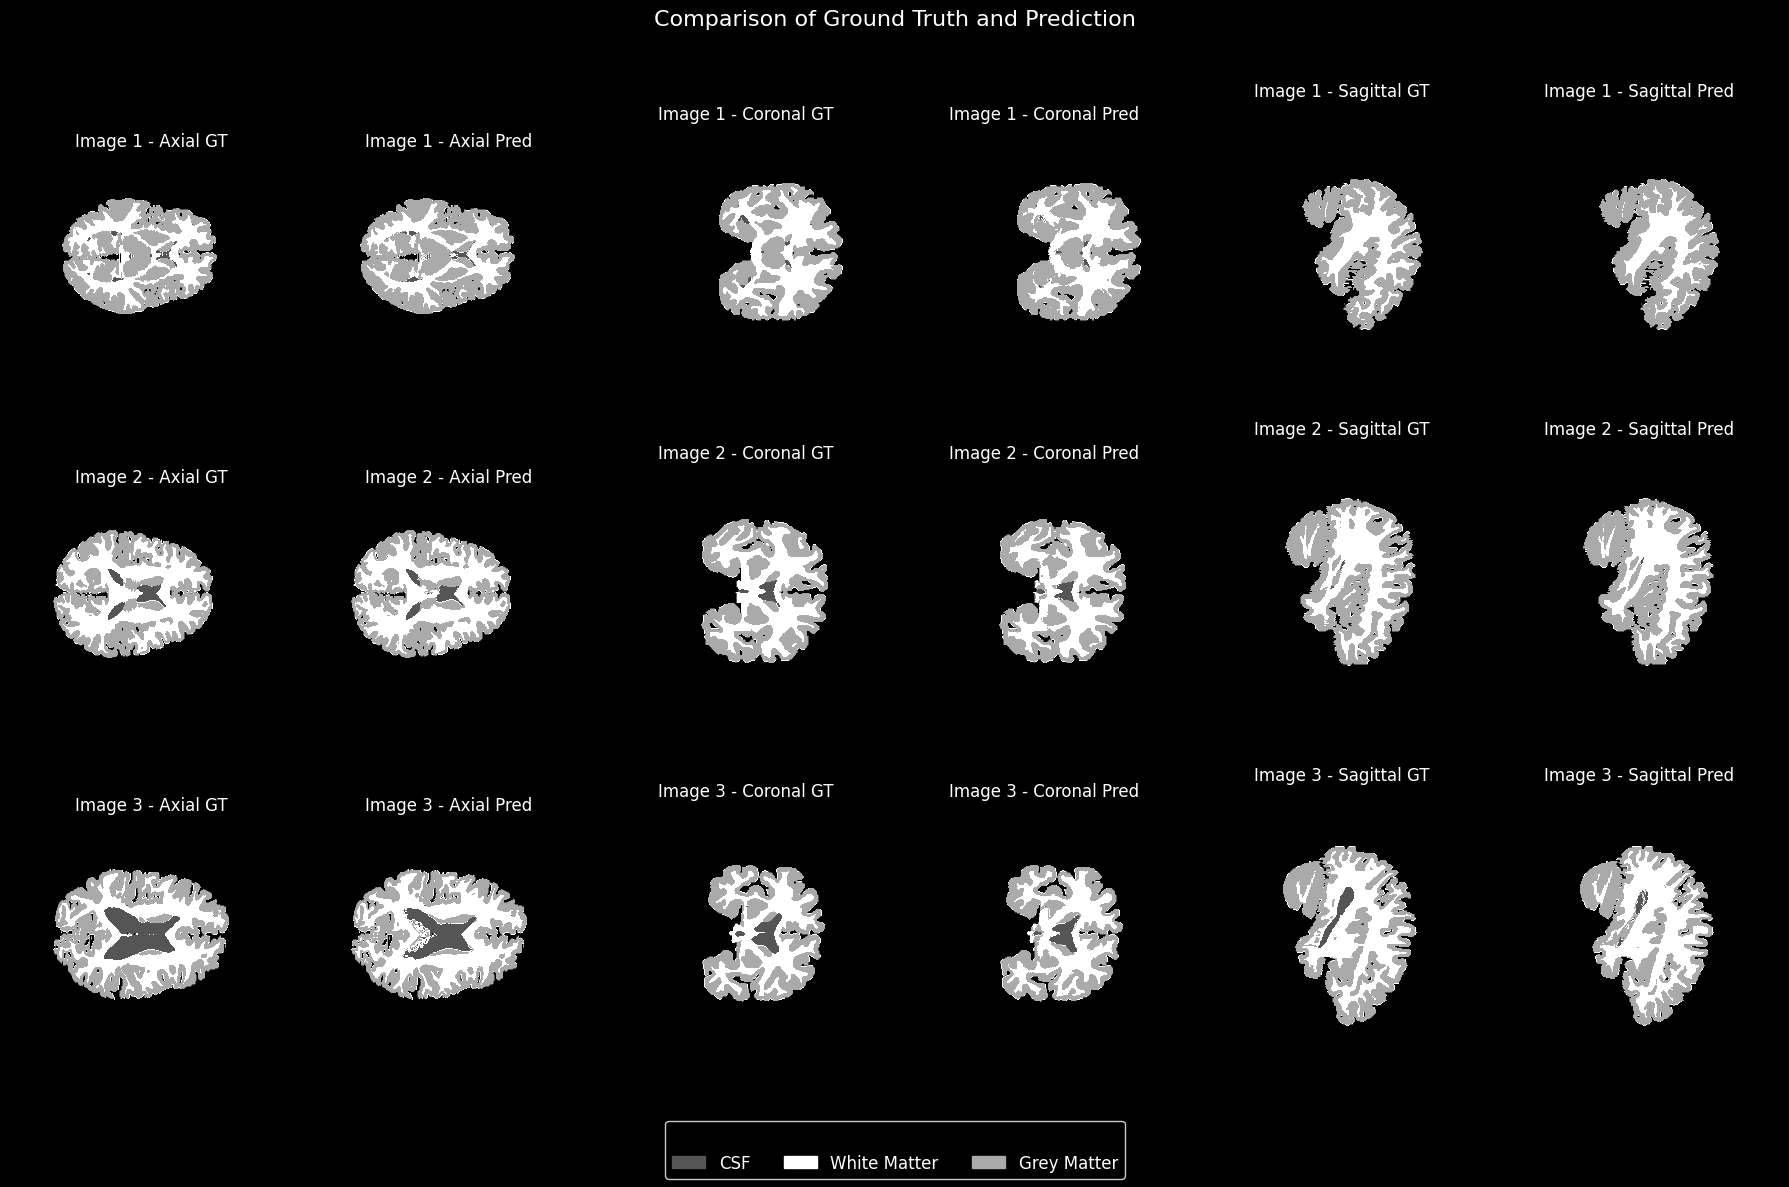

In [12]:
# load the ground truth and prediction
gt_masks = [readNiftiImage(mask_file)[0] for mask_file in mask_paths]

# Plot the comparison grid
plot_comparison_grid(predictions, gt_masks, slice_indices=[150, 150, 150], title="Comparison of Ground Truth and Prediction")



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



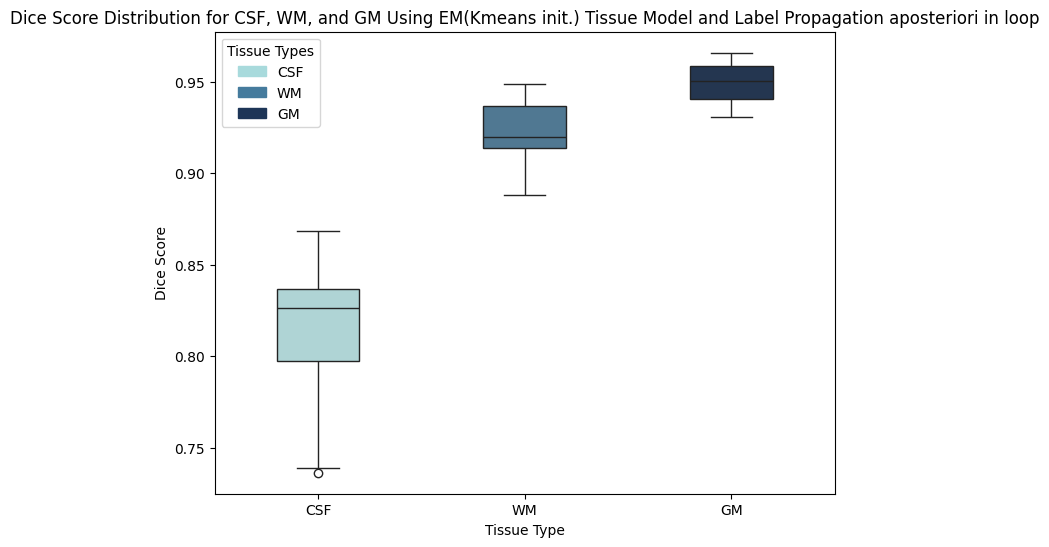

In [80]:
# Plot the Dice score boxplot

metrics_df = pd.read_csv('Result\\EM+Kmeans+TM+LP\\DiceScores_aposteriori.csv')
plot_dice_score_boxplot(metrics_df)

In [73]:
responsibilities_lp

array([[ 7.68390528e-21,  1.06430356e-03,  9.98935640e-01],
       [-1.58796563e-19, -1.14964321e-03,  1.00114965e+00],
       [-1.59454818e-19, -3.92961269e-03,  1.00392962e+00],
       ...,
       [-1.49262757e-22, -2.13860389e-04,  1.00021386e+00],
       [ 1.37242896e-23, -1.71310210e-03,  1.00171316e+00],
       [ 4.47757601e-22, -2.92303436e-03,  1.00292301e+00]])

In [ ]:
# Step-3 Calculate the initial parameters for the EM algorithm


n_samples = data.shape[0]

sigma_init = np.zeros((n_clusters, 1))

# Update sigma (standard deviations)
for i in range(n_clusters):
    diff = data - mu_init[i]
    sigma_init[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])

    # Update pi (mixing coefficients)
    pi_init = N_k / n_samples
    
mu_init, sigma_init, pi_init